In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import scipy.stats

from tqdm import tqdm
from collections import defaultdict
from models import MLP1Base, MLP2Base, MetaMLPModel

import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('./parallelograms-revisited/experiment3_data_symmetry/mean_asymmetry_ratings.csv')

In [3]:
df

,relation1,relation2,comparison_type,pair1_word1,pair1_word2,pair2_word1,pair2_word2,forward_rating,forward_n,backward_rating,backward_n
0,10a,10b,between-subtype,license,permission,yawn,boredom,3.760000,50,3.740000,50
1,8d,8e,between-subtype,breathe,live,athlete,medal,2.740000,50,2.764706,51
2,6e,6e,within-subtype,miser,splurge,miser,give,3.900000,50,3.980000,50
3,9h,9i,between-subtype,arrest,trial,foot,shoe,3.240000,50,2.745098,51
4,9a,9a,within-subtype,farm,tractor,bakery,cake,4.780000,50,4.470588,51
...,...,...,...,...,...,...,...,...,...,...,...
495,9h,1a,between-type,narrative,epilogue,animal,pig,2.800000,50,3.840000,50
496,2a,2b,between-subtype,bird,wings,pack,wolf,2.940000,50,2.080000,50
497,7h,7h,within-subtype,conductor,baton,queen,throne,4.880000,50,4.700000,50
498,1e,1c,between-subtype,lake,Erie,fish,trout,5.686275,51,6.137255,51


In [4]:
vocab = torchtext.vocab.GloVe(name='840B', dim=300)

In [8]:
meta_mlp2_params = torch.load('/n/fs/nlp-myhu/research-code/pytorch-maml/output/jan15_analogy/2021-01-15_091502mlp2/model.th', map_location=torch.device('cpu'))

In [9]:
meta_mlp2 = MLP2Base(input_dim=300, hidden_dim=500, output_dim=300)

In [10]:
meta_mlp2.l1.weight.data = meta_mlp2_params['features.layer1.linear.weight']
meta_mlp2.l1.bias.data = meta_mlp2_params['features.layer1.linear.bias']
meta_mlp2.l2.weight.data = meta_mlp2_params['features.layer2.linear.weight']
meta_mlp2.l2.bias.data = meta_mlp2_params['features.layer2.linear.bias']
meta_mlp2.l3.weight.data = meta_mlp2_params['classifier.weight']
meta_mlp2.l3.bias.data = meta_mlp2_params['classifier.bias']

In [11]:
mm2opt = optim.SGD(meta_mlp2.parameters(), lr=0.1)

mm2cache = meta_mlp2.state_dict()

criterion = nn.MSELoss()

def get_m2_loss(a, b, c, d):
    meta_mlp2.load_state_dict(mm2cache)
    mm2opt.zero_grad()
    a_hat = meta_mlp2(a)
    loss = criterion(a_hat, b)
    loss.backward()
    mm2opt.step()
    c_hat = meta_mlp2(c)
    loss = criterion(c_hat, d)
    return loss.detach().numpy()

In [12]:
angry = vocab['angry']
smile = vocab['smile']
exhausted = vocab['exhausted']
run = vocab['run']

In [13]:
print(np.exp(-get_m2_loss(angry, smile, exhausted, run)))
print(np.exp(-get_m2_loss(exhausted, run, angry, smile)))

0.34616262
0.4230812


In [14]:
torch.manual_seed(42)

In [15]:
def get_categorized_relsim_scores(df, vocab, get_loss, alpha):
    forward_dict = defaultdict(lambda: [])
    backward_dict = defaultdict(lambda: [])
    human_forward = defaultdict(lambda: [])
    human_backward = defaultdict(lambda: [])
    
    for idx, row in tqdm(df.iterrows()):
        w1, w2, w3, w4 = row['pair1_word1'], row['pair1_word2'], row['pair2_word1'], row['pair2_word2']

        if w1 not in vocab.stoi or w2 not in vocab.stoi or w3 not in vocab.stoi or w4 not in vocab.stoi:
            continue
            
        category_id = int(row['relation1'][:-1])
        
        forward_score = row['forward_rating']
        human_forward[category_id].append(forward_score)
        
        backward_score = row['backward_rating']
        human_backward[category_id].append(backward_score)
            
        a = vocab[w1]
        b = vocab[w2]
        c = vocab[w3]
        d = vocab[w4]
        
        forward = get_loss(a, b, c, d)
        backward = get_loss(c, d, a, b)

        forward_dict[category_id].append(np.exp(-alpha *forward))
        backward_dict[category_id].append(np.exp(-alpha * backward))
        
    return forward_dict, backward_dict, human_forward, human_backward

In [24]:
forward_dict, backward_dict, human_forward, human_backward = get_categorized_relsim_scores(df, vocab, get_m2_loss, 10)

500it [00:04, 117.29it/s]


In [25]:
forward_dict

defaultdict(<function __main__.get_categorized_relsim_scores.<locals>.<lambda>>,
            {10: [0.378504243926877,
              0.2789197065095022,
              0.23297136259766046,
              0.3275776292174034,
              0.2973262553002889,
              0.4020293345971462,
              0.4702748849585119,
              0.415612146985309,
              0.29971850996580895,
              0.33764517961357116,
              0.4789023562681159,
              0.32290654631919186,
              0.49170268817577895,
              0.12891312407034955,
              0.2866913813040832,
              0.3510992798302444,
              0.2925336132737737,
              0.4083022917049653,
              0.33790668229101317,
              0.42241778096447063,
              0.34113293497776426,
              0.30430540448075727,
              0.28422631078177824,
              0.1888668406706104,
              0.25200674022246455,
              0.3672268824049692,
              0.58946

In [26]:
def get_category_coeffs(word_dict, pred_dict):
    r_list = [0] * (len(word_dict)+1)

    for key, val in word_dict.items():
        pred = pred_dict[key]
        # pred = np.exp(np.array(pred))
        corr, pval = scipy.stats.pearsonr(val, pred)
        r_list[key] = corr
        
    return r_list[1:]

In [27]:
forward_corr = get_category_coeffs(human_forward, forward_dict)
backward_corr = get_category_coeffs(human_backward, backward_dict)

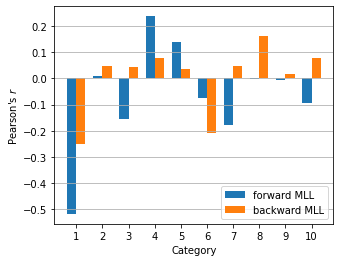

In [28]:
N = 10

fig, ax = plt.subplots(figsize=(5, 4))
ind = np.arange(10)
width = 0.35
p1 = ax.bar(ind, forward_corr, width)
p2 = ax.bar(ind+width, backward_corr, width)

# ax.set_title("Pearson's $r$ by category")
ax.set_xlabel('Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
ax.grid(axis='y')

ax.legend((p1[0], p2[0]), ('forward MLL', 'backward MLL'))
ax.set_ylabel("Pearson's $r$")
# ax.set_ylim(bottom=-0.4, top=0.6)
ax.autoscale_view()

In [44]:
def get_max(forward_dict):
    tmp = []
    for key, val in forward_dict.items():
        max = np.max(val)
        tmp.append(max)
    return np.max(tmp)

In [45]:
forward_max = get_max(forward_dict)
backward_max = get_max(backward_dict)

In [46]:
print(forward_max, backward_max)

1.619275 1.3829886


In [47]:
def get_converted_category_coeffs(word_dict, pred_dict):
    r_list = [0] * (len(word_dict)+1)

    for key, val in word_dict.items():
        pred = pred_dict[key]
        pred = np.array(pred)
        pred = pred / 1.62 * 6 + 1
        corr, pval = scipy.stats.pearsonr(val, pred)
        r_list[key] = corr
        
    return r_list[1:]

In [50]:
c_forward_corr = get_converted_category_coeffs(forward_dict, human_forward)
c_backward_corr = get_converted_category_coeffs(backward_dict, human_backward)

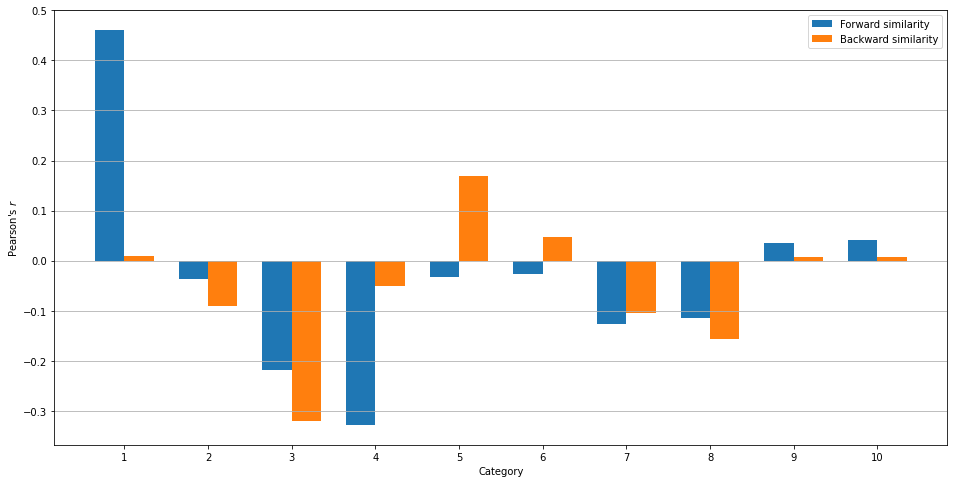

In [51]:
N = 10

fig, ax = plt.subplots(figsize=(16, 8))
ind = np.arange(10)
width = 0.35
p1 = ax.bar(ind, c_forward_corr, width)
p2 = ax.bar(ind+width, c_backward_corr, width)

# ax.set_title("Pearson's $r$ by category")
ax.set_xlabel('Category')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels((1, 2, 3, 4, 5, 6, 7, 8, 9, 10))
ax.grid(axis='y')

ax.legend((p1[0], p2[0]), ('Forward similarity', 'Backward similarity'))
ax.set_ylabel("Pearson's $r$")

ax.autoscale_view()